# Breast cancer classification with Deep Learning

- The breast cancer histology image dataset

![image](https://pyimagesearch.com/wp-content/uploads/2019/02/breast_cancer_classification_dataset.jpg)

Dataset information 
 - Slide images are naturally massive (in terms of spatial dimensions), so in order to make them easier to work with, a total of 277,524 patches of 50×50 pixels were extracted, including:

  - 198,738 negative examples (i.e., no breast cancer)
  - 78,786 positive examples (i.e., indicating breast cancer was found in the patch)


[LINK TO DATASET](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

### getting data from kaggle


In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manideep0703","key":"ad52a70f9cac346e06c1c513f3f79c42"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [01:08<00:00, 56.1MB/s]
100% 3.10G/3.10G [01:08<00:00, 48.8MB/s]


In [5]:
%mkdir dataset
%mkdir dataset/orig
%cd dataset/orig


/content/dataset/orig


In [6]:
!unzip /content/breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2351_class0.png  
  inflating: IDC_regular_

In [0]:
!rm -rf /content/dataset/orig/IDC_regular_ps50_idx5

In [8]:
%cd /content/dataset
%mkdir idc

/content/dataset


## DATA PREPARATION

In [0]:
import os

dataset = '/content/dataset/orig'
base_path = '/content/dataset/idc'

train_path = os.path.sep.join([base_path,'train'])
val_path = os.path.sep.join([base_path,'val'])
test_path = os.path.sep.join([base_path,'test'])

train_split = 0.8
val_split = 0.1

In [0]:
from imutils import paths
import random
import shutil
from tqdm import tqdm
import os

In [0]:
image_paths = list(paths.list_images(dataset))

In [0]:
random.shuffle(image_paths)

i = int(len(image_paths)*train_split)
train_paths = image_paths[:i]
test_paths = image_paths[i:]

i = int(len(train_paths)*val_split)
val_paths = image_paths[:i]
train_paths = image_paths[i:]

datasets = [
	("training", train_paths, train_path),
	("validation", val_paths, val_path),
	("testing", test_paths, test_path)
]

In [13]:
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))
	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)
	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image and extract the
		# class label ("0" for "negative" and "1" for "positive")
		filename = inputPath.split(os.path.sep)[-1]
		label = filename[-5:-4]
		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])
		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)
		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating /content/dataset/idc/train' directory
[INFO] 'creating /content/dataset/idc/train/0' directory
[INFO] 'creating /content/dataset/idc/train/1' directory
[INFO] building 'validation' split
[INFO] 'creating /content/dataset/idc/val' directory
[INFO] 'creating /content/dataset/idc/val/1' directory
[INFO] 'creating /content/dataset/idc/val/0' directory
[INFO] building 'testing' split
[INFO] 'creating /content/dataset/idc/test' directory
[INFO] 'creating /content/dataset/idc/test/1' directory
[INFO] 'creating /content/dataset/idc/test/0' directory


## BUILDING MODEL

In [14]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K

Using TensorFlow backend.


In [0]:
class CancerNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        if K.image_data_format()=='channels_frist':
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL
        model.add(SeparableConv2D(32, (3,3),padding='same',input_shape=inputShape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU => POOL) * 2
        model.add(SeparableConv2D(64,(3,3),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(64,(3,3),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        # (CONV => RELU => POOL) * 3
        model.add(SeparableConv2D(128,(3,3),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(128,(3,3),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(128,(3,3),padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(classes))
        model.add(Activation('softmax'))

        return model

### SETING UP SOME PARAMETERS

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adagrad
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

In [0]:
num_epochs = 3
INIT_LR = 1e-2
BS = 32

trainPaths = list(paths.list_images(train_path))
totalTrain = len(trainPaths)
totalVal = len(list(paths.list_images(val_path)))
totalTest = len(list(paths.list_images(test_path)))

trainLabels = [int(p.split(os.path.sep)[-2])for p in trainPaths]
trainLabels = np_utils.to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = classTotals.max()/classTotals


### CREATING DATA GENERATORS

In [0]:
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)


In [19]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
    train_path,
    class_mode='categorical',
    target_size=(48,48),
    color_mode='rgb',
    shuffle=True,
    batch_size=BS
)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	val_path,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS
)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	test_path,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS
)

Found 255323 images belonging to 2 classes.
Found 22201 images belonging to 2 classes.
Found 55505 images belonging to 2 classes.


## COMPILE MODEL AND RUNNING MODEL 

In [22]:
model = CancerNet.build(width=48,height=48,depth=3,classes=2)

opt = Adagrad(lr=INIT_LR,decay=INIT_LR/num_epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	class_weight=classWeight,
	epochs=num_epochs)

Epoch 1/3
7978/7978 [==============================] - 436s 55ms/step - loss: 0.3955 - accuracy: 0.8349 - val_loss: 0.2338 - val_accuracy: 0.7937
Epoch 2/3
7978/7978 [==============================] - 420s 53ms/step - loss: 0.3801 - accuracy: 0.8395 - val_loss: 0.4701 - val_accuracy: 0.8022
Epoch 3/3
7978/7978 [==============================] - 413s 52ms/step - loss: 0.3786 - accuracy: 0.8398 - val_loss: 0.1594 - val_accuracy: 0.8042


In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_7 (Separabl (None, 48, 48, 32)        155       
_________________________________________________________________
activation_9 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 24, 24, 64)        2400      
_________________________________________________________________
activation_10 (Activation)   (None, 24, 24, 64)       

## EVALUATING MODEL 


In [24]:
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
	steps=(totalTest // BS) + 1)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,target_names=testGen.class_indices.keys()))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.93      0.79      0.86     39772
           1       0.62      0.85      0.72     15733

    accuracy                           0.81     55505
   macro avg       0.77      0.82      0.79     55505
weighted avg       0.84      0.81      0.82     55505



In [25]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testGen.classes, predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[31578  8194]
 [ 2388 13345]]
acc: 0.8094
sensitivity: 0.7940
specificity: 0.8482


### PLOTING MODEL PERFORMANCE


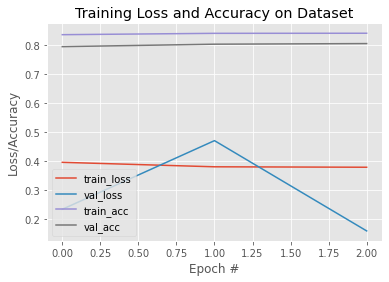

In [29]:
N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
